                      precision  recall  f1-score  support
Normal mode               0.989   0.989     0.989  731.000
Partial discharge         0.973   0.947     0.960   38.000
Low energy discharge      0.885   0.939     0.911   49.000
Low-temp overheating      0.912   0.890     0.901   82.000
accuracy                  0.976   0.976     0.976    0.976
macro avg                 0.940   0.941     0.940  900.000
weighted avg              0.976   0.976     0.976  900.000


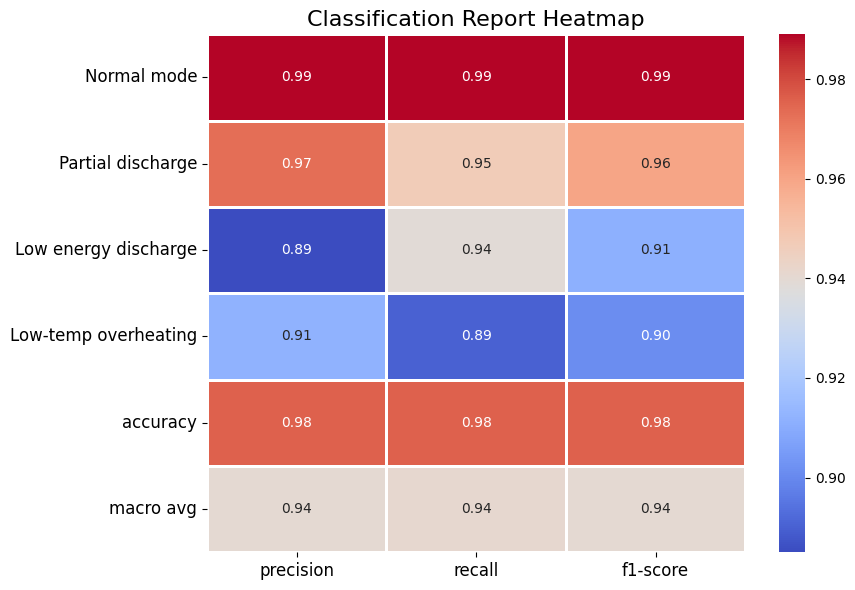

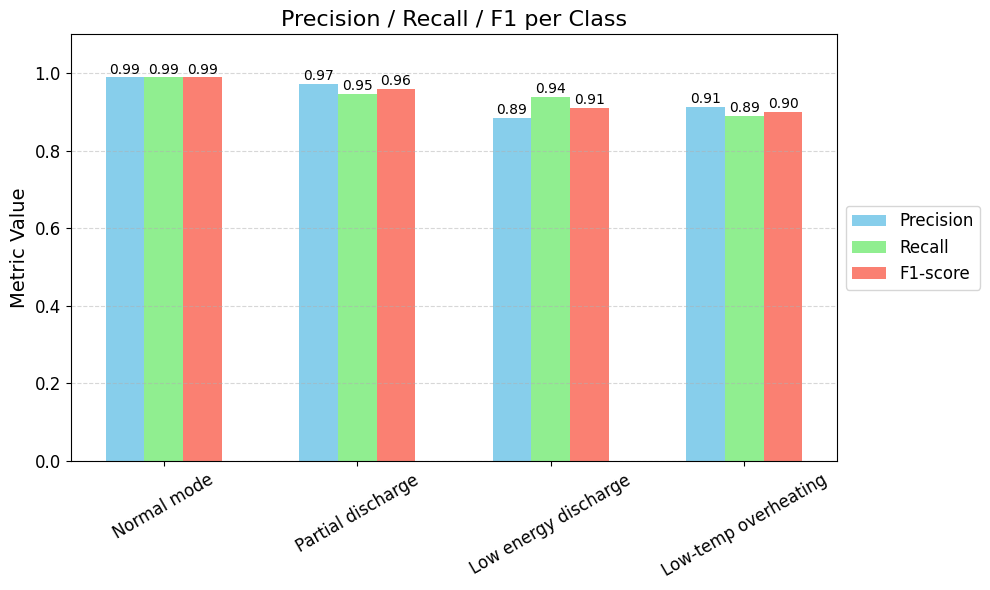

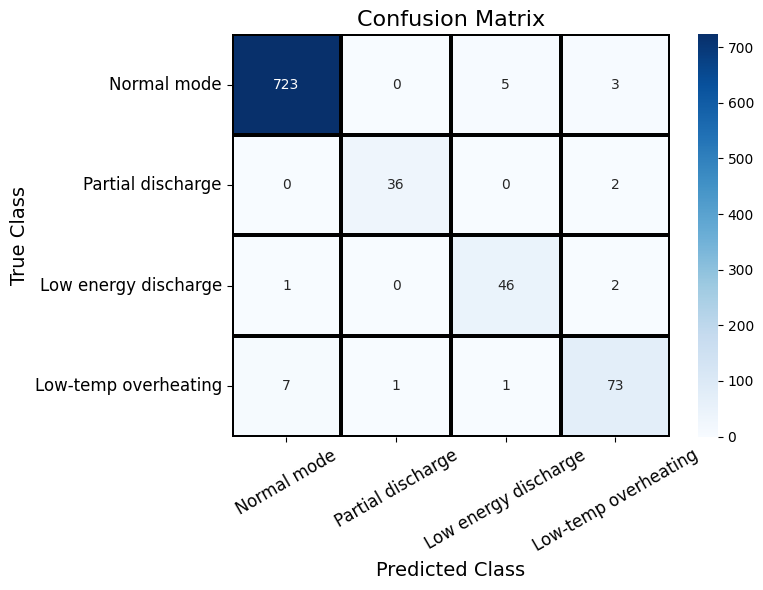

C:\Users\r\AppData\Local\Temp\ipykernel_12268\2403924764.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importances", y="Feature Name", data=fi_sorted.head(20), palette="viridis")


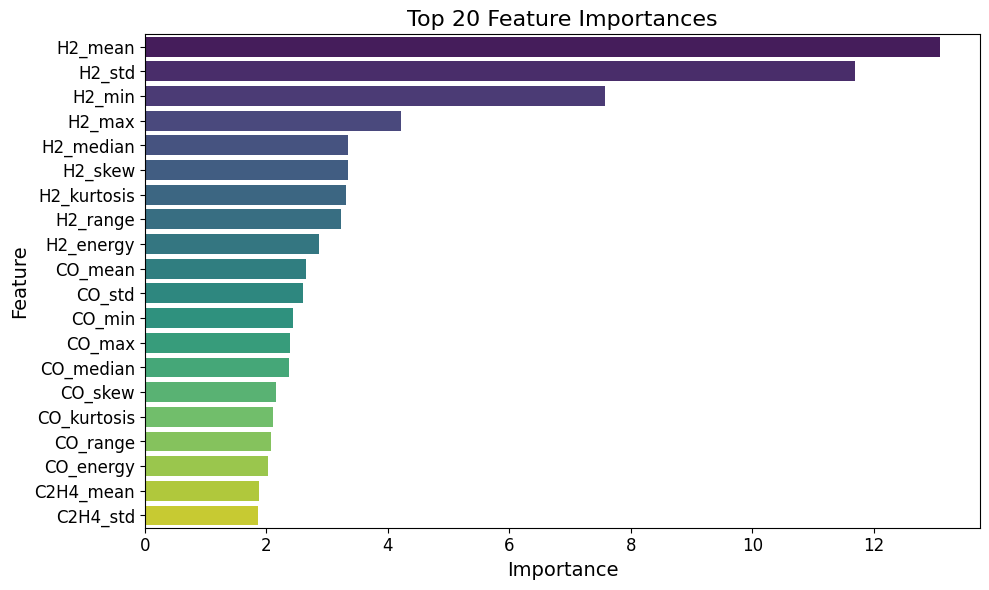

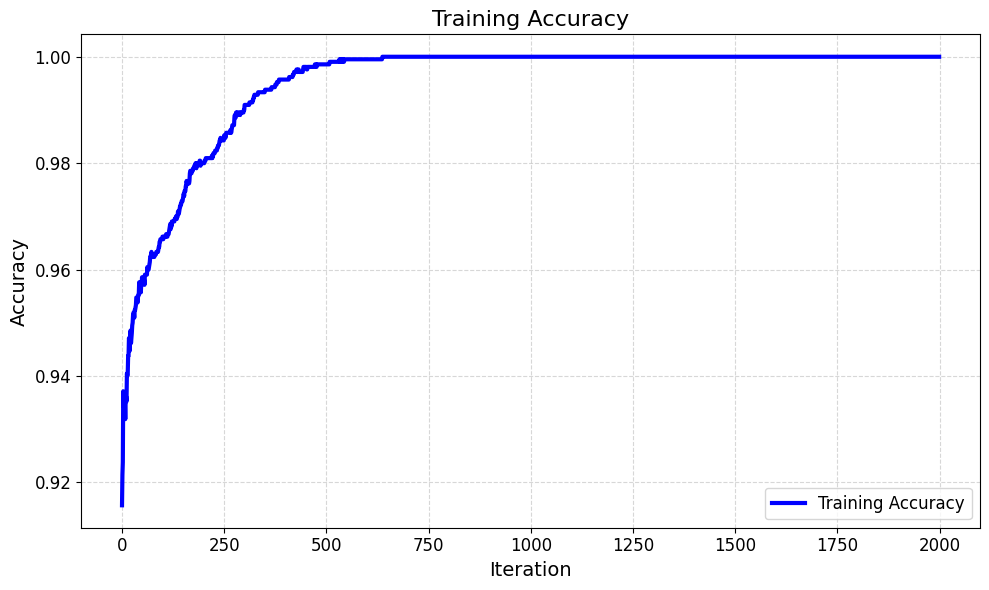

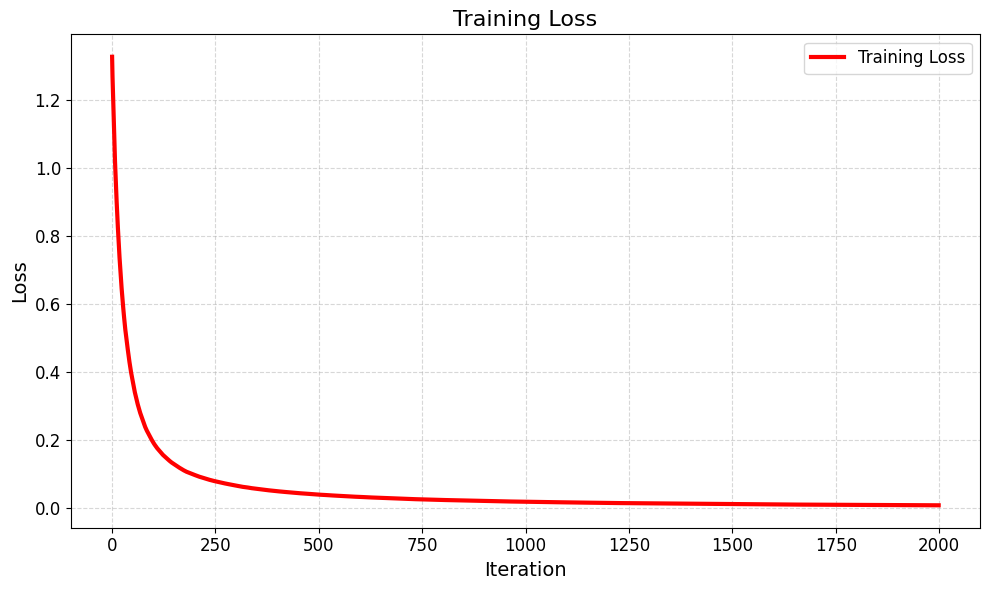

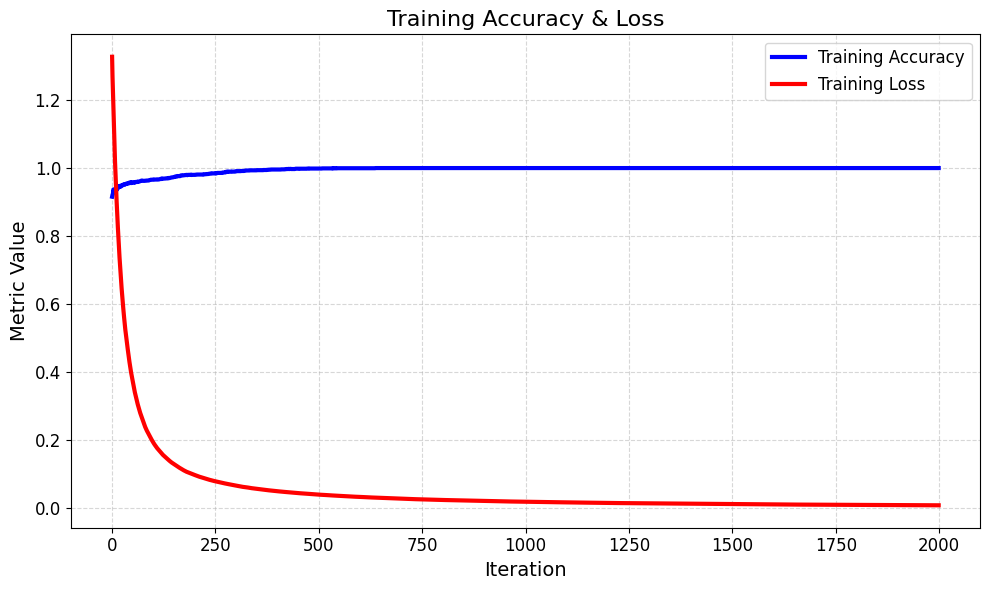

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from catboost import CatBoostClassifier, Pool

# -------------------------
# 0️⃣ Create folder for results
# -------------------------
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# -------------------------
# 1️⃣ Load model, scaler, test data
# -------------------------
cat_model = joblib.load("model/catboost_model_full.pkl")
scaler = joblib.load("model/scaler.pkl")

X_test = pd.read_csv("processed_data/test_features.csv").drop(columns=["id"])
y_test = pd.read_csv("processed_data/test_labels.csv")["category"]

# -------------------------
# 2️⃣ Feature Engineering
# -------------------------
X_test["H2_CO_ratio"] = X_test["H2_mean"] / (X_test["CO_mean"] + 1e-6)
X_test["C2H4_C2H2_ratio"] = X_test["C2H4_mean"] / (X_test["C2H2_mean"] + 1e-6)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 3️⃣ Predictions
# -------------------------
y_pred = cat_model.predict(X_test_scaled).flatten().astype(int)

category_mapping = {
    1: "Normal mode",
    2: "Partial discharge",
    3: "Low energy discharge",
    4: "Low-temp overheating"
}

# -------------------------
# 4️⃣ Classification Report
# -------------------------
report_dict = classification_report(
    y_test, y_pred, target_names=category_mapping.values(), output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose().round(3)
report_df.to_csv(os.path.join(results_dir, "catboost_classification_report.csv"), index=True)
print(report_df)

# Heatmap of classification report
plt.figure(figsize=(9,6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="coolwarm", fmt=".2f", linewidths=1, cbar=True)
plt.title("Classification Report Heatmap", fontsize=16)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "classification_report_heatmap.png"), dpi=300)
plt.show()

# -------------------------
# 5️⃣ F1, Recall, Accuracy per class Bar Plot
# -------------------------
# Only four classes
class_metrics = report_df.iloc[:4][['precision','recall','f1-score']].copy()
class_names = class_metrics.index.tolist()

# Values
precision = class_metrics['precision'].values
recall = class_metrics['recall'].values
f1 = class_metrics['f1-score'].values

# Bar width and positions
bar_width = 0.2
x = np.arange(len(class_names))

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
bars2 = plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
bars3 = plt.bar(x + bar_width, f1, width=bar_width, label='F1-score', color='salmon')

# Add values on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', fontsize=10)

plt.xticks(x, class_names, rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Metric Value", fontsize=14)
plt.title("Precision / Recall / F1 per Class", fontsize=16)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Move legend to the right of the plot
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "class_metrics_bar_grouped.png"), dpi=300, bbox_inches='tight')
plt.show()
# -------------------------
# 6️⃣ Confusion Matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_mapping.values(),
            yticklabels=category_mapping.values(),
            linewidths=1.5, linecolor='black')
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=30, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "confusion_matrix.png"), dpi=300)
plt.show()

# -------------------------
# 7️⃣ Feature Importance (Actual Feature Names)
# -------------------------
feature_names = X_test.columns.tolist()
fi = cat_model.get_feature_importance(prettified=True)
fi['Feature Name'] = feature_names
fi_sorted = fi.sort_values(by="Importances", ascending=False)
fi_sorted.to_csv(os.path.join(results_dir, "catboost_feature_importance.csv"), index=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importances", y="Feature Name", data=fi_sorted.head(20), palette="viridis")
plt.title("Top 20 Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "feature_importance.png"), dpi=300)
plt.show()

# -------------------------
# 8️⃣ Training Curves
# -------------------------
with open("model/catboost_train_accuracy.json", "r") as f:
    train_acc = json.load(f)
with open("model/catboost_train_loss.json", "r") as f:
    train_loss = json.load(f)
iterations = range(len(train_acc))

# Accuracy Plot
plt.figure(figsize=(10,6))
plt.plot(iterations, train_acc, label="Training Accuracy", color="blue", linewidth=3)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Training Accuracy", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "training_accuracy.png"), dpi=300)
plt.show()

# Loss Plot
plt.figure(figsize=(10,6))
plt.plot(iterations, train_loss, label="Training Loss", color="red", linewidth=3)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training Loss", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "training_loss.png"), dpi=300)
plt.show()

# Combined Plot
plt.figure(figsize=(10,6))
plt.plot(iterations, train_acc, label="Training Accuracy", color="blue", linewidth=3)
plt.plot(iterations, train_loss, label="Training Loss", color="red", linewidth=3)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.title("Training Accuracy & Loss", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "training_accuracy_loss.png"), dpi=300)
plt.show()


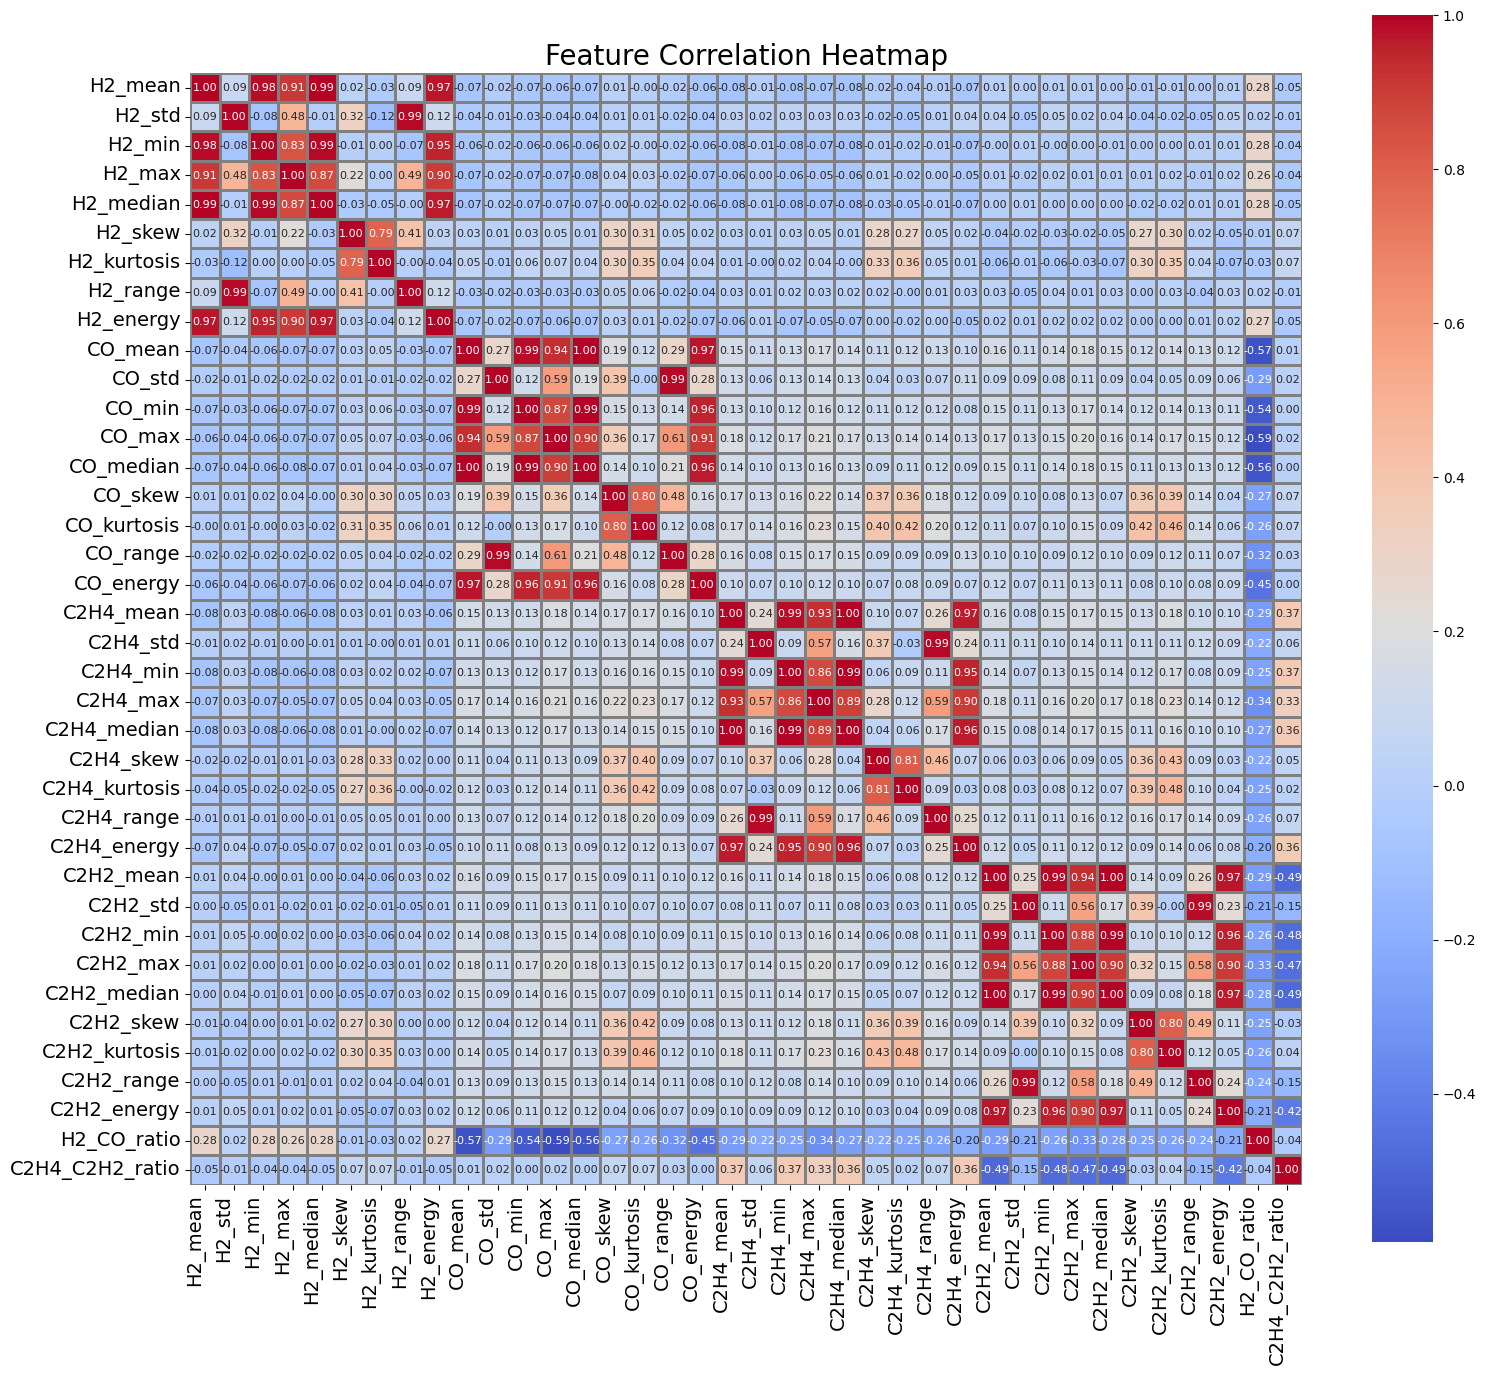

In [12]:
# -------------------------
# 7️⃣ Feature Correlation Heatmap (Clean)
# -------------------------
corr_matrix = X_test.corr()

plt.figure(figsize=(16,14))  # larger figure
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",           # 2 decimal places
    cmap="coolwarm",
    linewidths=1,
    linecolor='gray',
    cbar=True,
    square=True,
    annot_kws={"size":8}  # smaller annotation font
)

plt.title("Feature Correlation Heatmap", fontsize=20)
plt.xticks(rotation=90, ha='right', fontsize=14)  # tilted for better fit
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "feature_correlation_heatmap.png"), dpi=300)
plt.show()
